# Exploratoty Data Analysis for Tobacco

## Overview
In this file two datasets are used i.e Tobacco and Mortality data
### Key section:
1. Datasets 
2. SQL connection and inserting Data IN SQL 
3. Filling out missing values for Tobacco Data
4. Exploratory data analysis for Tobacco dataset specifically for Canada
5. Joining Tobacco Data with mortality: to see if tobacco use has any impact on one of the diseases
6. Visualization

## Dataset


Tobacco Dataset:</br>
https://www.who.int/data/gho/data/indicators/indicator-details/GHO/gho-tobacco-control-monitor-current-tobaccouse-tobaccosmoking-cigarrettesmoking-agestd-tobagestdcurr</br>
Mortality Dataset:</br>
https://www.who.int/data/gho/data/indicators/indicator-details/GHO/number-of-deaths-attributed-to-non-communicable-diseases-by-type-of-disease-and-sex</br>

In [6]:
import pandas as pd
import sqlalchemy as sq
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
tobacco=pd.read_csv(r"Data\Global_Tobacco.csv", encoding='ISO-8859-1')
mortality=pd.read_csv(r"Data\Global_Moratlity.csv")

## Sql Connection, Renaming Columns and inserting to sql


In [8]:
username = 'root'
password = 'abc123'
host = 'localhost'  
port = '3306'       
database = 'project'

connection_url = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"
engine = sq.create_engine(connection_url)

In [9]:
tobacco.rename(columns={"Indicator":"Indicator", "ParentLocation":"Region", "Location":"Country", "Period":"Year",
                         "Dim1":"Gender", "FactValueNumeric":"tobacco_value", "FactValueNumericLow": "tobacco_value_low",
                           "FactValueNumericHigh":"tobacco_value_high", "Value": "tobacco_range"}, inplace=True)

#inserting Tobbacco data in sql table
tobacco.to_sql("tobacco", engine, index=False,if_exists='replace')
tobacco = pd.read_sql_table("tobacco", engine)
tobacco.head()

,Indicator,Region,Country,Year,Gender,tobacco_value,tobacco_value_low,tobacco_value_high,tobacco_range
0,Estimate of current tobacco use prevalence (%)...,South-East Asia,Democratic People's Republic of Korea,2030,Female,0.0,0.0,0.0,0 [0-0]
1,Estimate of current tobacco use prevalence (%)...,Europe,Azerbaijan,2030,Female,0.1,0.0,0.2,0.1 [0-0.2]
2,Estimate of current tobacco use prevalence (%)...,Africa,Ghana,2030,Female,0.2,0.1,0.3,0.2 [0.1-0.3]
3,Estimate of current tobacco use prevalence (%)...,Eastern Mediterranean,Egypt,2030,Female,0.3,0.1,0.4,0.3 [0.1-0.4]
4,Estimate of current tobacco use prevalence (%)...,Africa,Nigeria,2030,Female,0.3,0.1,0.5,0.3 [0.1-0.5]


In [10]:
mortality.rename(columns={"ParentLocation":"Region", "Location":"Country", "Period":"Year",
                         "Dim1":"Gender","Dim2":"Disease", "FactValueNumeric":"mortality_value", "FactValueNumericLow": "mortality_value_low",
                           "FactValueNumericHigh":"mortality_value_high", "Value": "mortality_range"}, inplace=True)

#inserting mortality data in sql table
mortality.to_sql("mortality", engine, index=False,if_exists='replace')
mortality = pd.read_sql_table("mortality", engine)
mortality.head()

,Region,Country,Year,Gender,Disease,mortality_value,mortality_value_low,mortality_value_high,mortality_range
0,South-East Asia,Timor-Leste,2019,Male,Diabetes mellitus,99.53,49.54,167.8,100 [50-168]
1,South-East Asia,Bhutan,2019,Female,Diabetes mellitus,100.20,56.06,163.0,100 [56-163]
2,Europe,Montenegro,2019,Both sexes,Respiratory diseases,100.00,63.92,145.0,100 [64-145]
3,Africa,Seychelles,2019,Male,Malignant neoplasms,99.63,66.17,144.1,100 [66-144]
4,Africa,Lesotho,2019,Male,Diabetes mellitus,1003.00,580.00,1612.0,1003 [580-1612]


## Filling Null Values for Tobacco

In [22]:
query1 = """
WITH AvailableYears AS (
    SELECT DISTINCT Year, Country, Gender, tobacco_value, tobacco_value_low, tobacco_value_high
    FROM tobacco
    WHERE Year IN (2000, 2005, 2007, 2010, 2015, 2020)
),
YearRanges AS (
    SELECT 2001 AS MissingYear, 2000 AS PrevYear, 2005 AS NextYear UNION ALL
    SELECT 2002, 2000, 2005 UNION ALL
    SELECT 2003, 2000, 2005 UNION ALL
    SELECT 2004, 2000, 2005 UNION ALL
    SELECT 2006, 2005, 2007 UNION ALL
    SELECT 2008, 2007, 2010 UNION ALL
    SELECT 2009, 2007, 2010 UNION ALL
    SELECT 2011, 2010, 2015 UNION ALL
    SELECT 2012, 2010, 2015 UNION ALL
    SELECT 2013, 2010, 2015 UNION ALL
    SELECT 2014, 2010, 2015 UNION ALL
    SELECT 2016, 2015, 2020 UNION ALL
    SELECT 2017, 2015, 2020 UNION ALL
    SELECT 2018, 2015, 2020 UNION ALL
    SELECT 2019, 2015, 2020
),
CalculatedAverages AS (
    SELECT 
        r.MissingYear,
        a1.Country,
        a1.Gender,
        AVG(a1.tobacco_value) AS avg_tobacco_value,
        AVG(a1.tobacco_value_low) AS avg_tobacco_value_low,
        AVG(a1.tobacco_value_high) AS avg_tobacco_value_high
    FROM YearRanges r
    JOIN AvailableYears a1 ON a1.Year IN (r.PrevYear, r.NextYear) AND a1.Country = a1.Country
    GROUP BY r.MissingYear, a1.Country, a1.Gender
)
SELECT 
    'Estimate of current tobacco use prevalence' AS Indicator,
    'Americas' AS Region,
    c.Country,
    c.MissingYear AS Year,
    c.Gender,
    c.avg_tobacco_value AS Tobacco_value,
    c.avg_tobacco_value_low AS Tobacco_value_low,
    c.avg_tobacco_value_high AS Tobacco_value_high,
    NULL AS tobacco_range
FROM CalculatedAverages c;
"""

# Assuming you have a connection object named engine
result = pd.read_sql_query(query1, engine)
result.to_sql('tobacco', con=engine, if_exists='append', index=False)
tobacco = pd.read_sql_table("tobacco", engine)
tobacco.tail(5)

,Indicator,Region,Country,Year,Gender,tobacco_value,tobacco_value_low,tobacco_value_high,tobacco_range
27220,Estimate of current tobacco use prevalence,Americas,Albania,2001,Female,10.35,7.90,12.85,None
27221,Estimate of current tobacco use prevalence,Americas,Chad,2004,Both sexes,10.40,7.65,13.20,None
27222,Estimate of current tobacco use prevalence,Americas,Chad,2003,Both sexes,10.40,7.65,13.20,None
27223,Estimate of current tobacco use prevalence,Americas,Chad,2002,Both sexes,10.40,7.65,13.20,None
27224,Estimate of current tobacco use prevalence,Americas,Chad,2001,Both sexes,10.40,7.65,13.20,None


## Exploratoring Tobacco data

In [12]:
# Rank of Canada for average tobacco use in past 18 years among 165 countries
query = """WITH RankedTobacco AS (SELECT country, AVG(Tobacco_value) AS avg_tobacco, RANK() OVER (ORDER BY AVG(Tobacco_value) DESC) AS rank_value
    FROM tobacco WHERE Gender = 'Both sexes' AND Year >= 2000 AND Year <= 2018 GROUP BY country)
    SELECT country, avg_tobacco, rank_value FROM RankedTobacco WHERE country = 'Canada';"""
print("Canada rank for average TObacco use out of 165 countries")
ranked_data = pd.read_sql_query(query, engine)
ranked_data

Canada rank for average TObacco use out of 165 countries


,country,avg_tobacco,rank_value
0,Canada,20.534211,104


In [13]:
# Rank of Canada for tobacco use in 2018 among 165 countries
query = """ WITH RankedTobacco AS ( SELECT country, Tobacco_value, RANK() OVER (ORDER BY Tobacco_value DESC) AS rank_value
    FROM tobacco WHERE Gender = 'Both sexes' AND Year = 2018) SELECT country, Tobacco_value, rank_value
    FROM RankedTobacco WHERE country = 'Canada';"""
ranked_data = pd.read_sql_query(query, engine)
print("Rank of Canada out of 165 countries in 2018")
ranked_data.head()


Rank of Canada out of 165 countries in 2018


,country,Tobacco_value,rank_value
0,Canada,14.4,116


In [14]:
# Rank of Canada for tobacco use in 2000 among 165 countries
query = """ WITH RankedTobacco AS ( SELECT country, Tobacco_value, RANK() OVER (ORDER BY Tobacco_value DESC) AS rank_value
    FROM tobacco WHERE Gender = 'Both sexes' AND Year = 2000) SELECT country, Tobacco_value, rank_value
    FROM RankedTobacco WHERE country = 'Canada';"""
ranked_data = pd.read_sql_query(query, engine)
print("Rank of Canada out of 165 countries in 2000")
ranked_data.head()

Rank of Canada out of 165 countries in 2000


,country,Tobacco_value,rank_value
0,Canada,28.7,92


In [15]:
# Over all trend of tobacco use for males and females in recenty years in Canada
query = """SELECT Country,Year,Gender,tobacco_value, tobacco_value_low, tobacco_value_high FROM tobacco
 where year<=2018 and Country='Canada' and gender!='Both sexes' order by year DESC;
 """   
result=pd.read_sql_query(query, engine)
result

,Country,Year,Gender,tobacco_value,tobacco_value_low,tobacco_value_high
0,Canada,2018,Female,12.10,10.15,14.00
1,Canada,2018,Male,16.75,14.40,19.15
2,Canada,2017,Male,16.75,14.40,19.15
3,Canada,2017,Female,12.10,10.15,14.00
4,Canada,2016,Male,16.75,14.40,19.15
5,Canada,2016,Female,12.10,10.15,14.00
6,Canada,2015,Female,13.50,11.30,15.60
7,Canada,2015,Male,18.20,15.80,20.60
8,Canada,2014,Female,15.25,12.90,17.55
9,Canada,2014,Male,19.90,17.00,22.85


## Joining MORTALITY with tobacco

In [16]:
# Cardiovascular vs tobacco values to see if they have been increasing or decreasing over the years
query = """SELECT t.Country, t.Year, t.Gender,  t.tobacco_value, m.mortality_value, m.Disease FROM tobacco t
            JOIN mortality m ON t.Year = m.Year AND t.Gender = m.Gender and t.country=m.country
            WHERE t.Country = 'Canada' AND t.Year BETWEEN 2000 AND 2018 
            AND t.Gender= 'Both sexes' AND m.Disease = 'Cardiovascular diseases';"""   
result=pd.read_sql_query(query, engine)
result

,Country,Year,Gender,tobacco_value,mortality_value,Disease
0,Canada,2018,Both sexes,14.40,70147.0,Cardiovascular diseases
1,Canada,2017,Both sexes,14.40,71372.0,Cardiovascular diseases
2,Canada,2016,Both sexes,14.40,69553.0,Cardiovascular diseases
3,Canada,2015,Both sexes,15.80,69548.0,Cardiovascular diseases
4,Canada,2014,Both sexes,17.55,68507.0,Cardiovascular diseases
5,Canada,2013,Both sexes,17.55,67296.0,Cardiovascular diseases
6,Canada,2012,Both sexes,17.55,65860.0,Cardiovascular diseases
7,Canada,2011,Both sexes,17.55,65294.0,Cardiovascular diseases
8,Canada,2010,Both sexes,19.30,66670.0,Cardiovascular diseases
9,Canada,2009,Both sexes,20.45,67611.0,Cardiovascular diseases


In [20]:
# Respiratory diseases vs tobacco values to see if they have been increasing or decreasing over the years
query = """SELECT t.Country, t.Year, t.Gender,  t.tobacco_value, m.mortality_value, m.Disease FROM tobacco t
    JOIN mortality m ON t.Year = m.Year AND t.Gender = m.Gender and t.country=m.country
    WHERE t.Country = 'Canada' AND t.Year BETWEEN 2000 AND 2018 
    AND t.Gender= 'Both sexes' AND m.Disease = 'Respiratory diseases';"""   
result=pd.read_sql_query(query, engine)
result

,Country,Year,Gender,tobacco_value,mortality_value,Disease
0,Canada,2018,Both sexes,14.40,19700.0,Respiratory diseases
1,Canada,2017,Both sexes,14.40,19973.0,Respiratory diseases
2,Canada,2016,Both sexes,14.40,18990.0,Respiratory diseases
3,Canada,2015,Both sexes,15.80,18873.0,Respiratory diseases
4,Canada,2014,Both sexes,17.55,17989.0,Respiratory diseases
5,Canada,2013,Both sexes,17.55,17848.0,Respiratory diseases
6,Canada,2012,Both sexes,17.55,17670.0,Respiratory diseases
7,Canada,2011,Both sexes,17.55,17578.0,Respiratory diseases
8,Canada,2010,Both sexes,19.30,16903.0,Respiratory diseases
9,Canada,2009,Both sexes,20.45,16665.0,Respiratory diseases


In [18]:
# Diabetes mellitus vs tobacco values to see if they have been increasing or decreasing over the years
query = """SELECT t.Country, t.Year, t.Gender,  t.tobacco_value, m.mortality_value, m.Disease FROM tobacco t
    JOIN mortality m ON t.Year = m.Year AND t.Gender = m.Gender and t.country=m.country
    WHERE t.Country = 'Canada' AND t.Year BETWEEN 2000 AND 2018 
    AND t.Gender= 'Both sexes' AND m.Disease='Diabetes mellitus';"""   
result=pd.read_sql_query(query, engine)
result

,Country,Year,Gender,tobacco_value,mortality_value,Disease
0,Canada,2018,Both sexes,14.40,6883.0,Diabetes mellitus
1,Canada,2017,Both sexes,14.40,7002.0,Diabetes mellitus
2,Canada,2016,Both sexes,14.40,6962.0,Diabetes mellitus
3,Canada,2015,Both sexes,15.80,7230.0,Diabetes mellitus
4,Canada,2014,Both sexes,17.55,7091.0,Diabetes mellitus
5,Canada,2013,Both sexes,17.55,7056.0,Diabetes mellitus
6,Canada,2012,Both sexes,17.55,7003.0,Diabetes mellitus
7,Canada,2011,Both sexes,17.55,7232.0,Diabetes mellitus
8,Canada,2010,Both sexes,19.30,6964.0,Diabetes mellitus
9,Canada,2009,Both sexes,20.45,6938.0,Diabetes mellitus


In [19]:
# Malignant neoplasms(cancer) vs tobacco values to see if they have been increasing or decreasing over the years
query = """SELECT t.Country, t.Year, t.Gender,  t.tobacco_value, m.mortality_value, m.Disease FROM tobacco t
    JOIN mortality m ON t.Year = m.Year AND t.Gender = m.Gender and t.country=m.country
    WHERE t.Country = 'Canada' AND t.Year BETWEEN 2000 AND 2018 
    AND t.Gender= 'Both sexes' AND m.Disease='Malignant neoplasms';"""   
result=pd.read_sql_query(query, engine)
result

,Country,Year,Gender,tobacco_value,mortality_value,Disease
0,Canada,2018,Both sexes,14.40,80881.0,Malignant neoplasms
1,Canada,2017,Both sexes,14.40,80994.0,Malignant neoplasms
2,Canada,2016,Both sexes,14.40,80696.0,Malignant neoplasms
3,Canada,2015,Both sexes,15.80,78020.0,Malignant neoplasms
4,Canada,2014,Both sexes,17.55,77763.0,Malignant neoplasms
5,Canada,2013,Both sexes,17.55,75755.0,Malignant neoplasms
6,Canada,2012,Both sexes,17.55,74983.0,Malignant neoplasms
7,Canada,2011,Both sexes,17.55,73328.0,Malignant neoplasms
8,Canada,2010,Both sexes,19.30,72535.0,Malignant neoplasms
9,Canada,2009,Both sexes,20.45,71726.0,Malignant neoplasms


## Visualization

int32


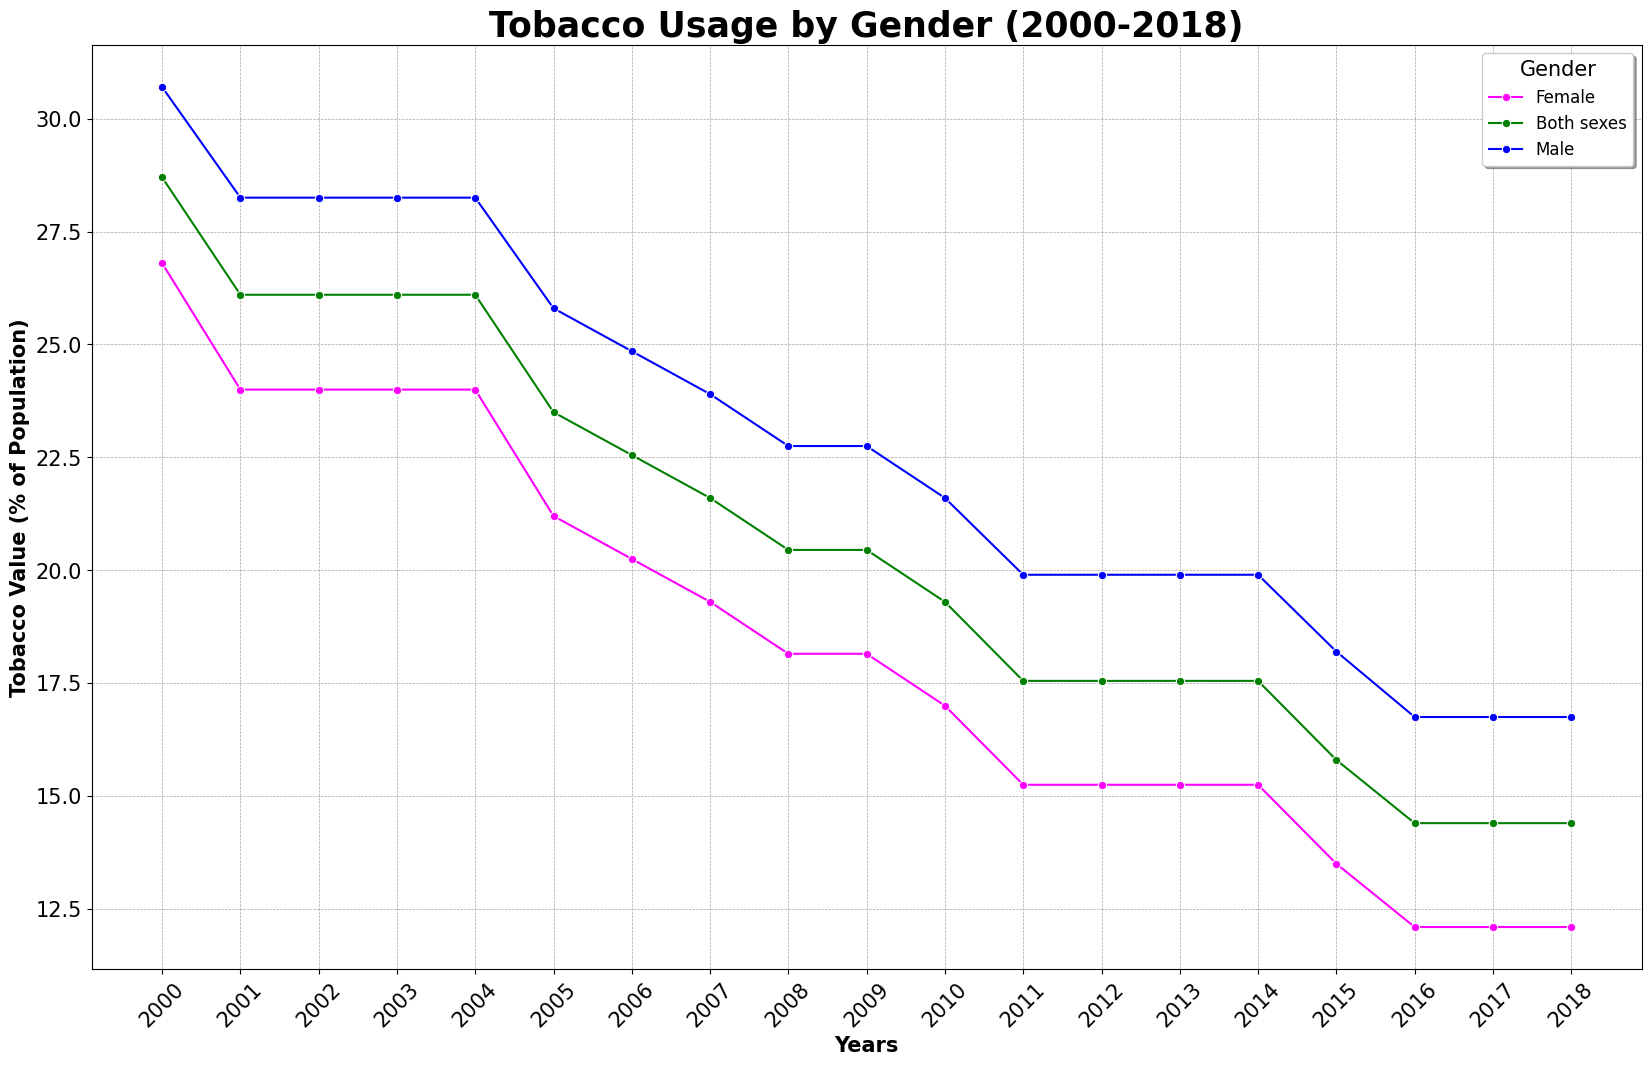

In [ ]:
#Trend line for tobacco use in canada from 2000-2018
query = """SELECT Year, tobacco_value, Gender FROM tobacco where year<=2018 and country='Canada';"""   
canada_tobacco=pd.read_sql_query(query, engine)
canada_tobacco['Year'] = canada_tobacco['Year'].astype(int)
plt.figure(figsize=(20, 12))

sns.lineplot(data=canada_tobacco, x=canada_tobacco['Year'], y=canada_tobacco['tobacco_value'], hue='Gender', marker='o', markersize=6, palette=['Magenta','Green','Blue'])
plt.title("Tobacco Usage by Gender (2000-2018)", fontsize=25, weight='bold')
plt.xlabel("Years", fontsize=15,weight='bold')
plt.ylabel("Tobacco Value (% of Population)", fontsize=15, weight='bold')
plt.legend(frameon=True, shadow=True, loc='upper right',fontsize=12,title="Gender", title_fontsize=15)
years = canada_tobacco['Year'].unique() 
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(years, rotation=45)
plt.xticks(ticks=years, labels=years, rotation=45,fontsize=15)
plt.yticks(fontsize=15)

# Show the plot
plt.savefig("Visuals/tobacco_trends_by_gender.png", format='png', dpi=300)
plt.show()


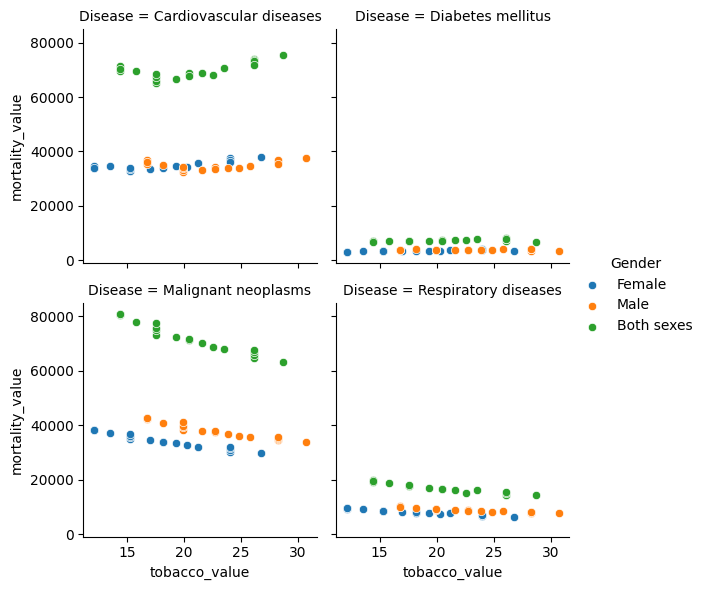

In [103]:
# Correlation between Tobacco and mortality diseases
query = """SELECT t.Country, t.Year, t.Gender,  t.tobacco_value, m.mortality_value, m.Disease FROM tobacco t
    JOIN mortality m ON t.Year = m.Year AND t.Gender = m.Gender and t.country=m.country
    WHERE t.Country = 'Canada' AND t.Year BETWEEN 2000 AND 2018 order by m.disease, m.year;"""   
result=pd.read_sql_query(query, engine)

pivot_df = result.pivot_table(index='Year', columns='Disease', values='mortality_value', aggfunc='first')
pivot_df = pivot_df.reset_index()
result = pd.merge(result, pivot_df, on='Year', how='left')

g = sns.FacetGrid(result, col="Disease", hue="Gender", col_wrap=2)  
g.map_dataframe(sns.scatterplot, x="tobacco_value", y="mortality_value")
g.add_legend()
plt.savefig("Visuals/tobacco_mortality pairplot.png", format='png', dpi=300)
plt.show()